## MSc652 Group 3433 GWP2

| Full Legal Name             | Location (Country) | Email Address             |
|----------------------------|--------------------|---------------------------|
| Chiransh Gulati            | US                 | gulatichiransh@gmail.com  |
| Harshil Sumra              | India              | harshilsumra1997@gmail.com|
| Pritam Biswaranjan Datta   | India              | pritamdattaedu@gmail.com  |

In [75]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cvxpy as cvx
import cvxopt as opt
from numpy.linalg import inv
import datetime as dt
import scipy.optimize as sco
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

### Step 1:</br>
a. Select a portfolio with a minimum of 5 securities. (Note that you should choose stocks for which you can find recent news, headlines, analyst reports, etc.)</br></br>b. Download daily or weekly returns for a period that allows you to have at least 100 data points (about 6 months daily returns, or 2 years of weekly returns). Assume you cannot short any securities.</br>

In [76]:
# Define the list of stock tickers
#tickers = ['ADANIENT.NS', 'TCS.NS', 'HDFCBANK.NS', 'DRREDDY.NS', 'ASIANPAINT.NS']
tickers = ['ASIANPAINT.NS', 'BAJAJFINSV.NS', 'DRREDDY.NS', 'HDFCBANK.NS', 'TCS.NS']

# Define the start and end dates. This will download 120 days of data for each stock
start_date = '2020-01-01'
end_date = '2023-06-30'

# Download historical price data
data = yf.download(tickers, start=start_date, end=end_date, period='1d', auto_adjust=True)['Close']

[*********************100%***********************]  5 of 5 completed


In [77]:
# Resample the data to weekly timeframe
data = data.resample('W').last()

# Access the weekly close prices
#data = weekly_data['Close']

In [78]:
data.head()

,ASIANPAINT.NS,BAJAJFINSV.NS,DRREDDY.NS,HDFCBANK.NS,TCS.NS
Date,,,,,
2020-01-05,1705.829712,932.517639,2801.148682,1234.264160,2049.801758
2020-01-12,1745.908813,935.151794,2848.840332,1248.179321,2061.817139
2020-01-19,1782.433472,969.351074,2947.281982,1243.751831,2066.986572
2020-01-26,1740.308594,961.243958,2944.416016,1211.056152,2038.351807
2020-02-02,1748.928467,942.051575,3025.132080,1193.297241,1940.934326


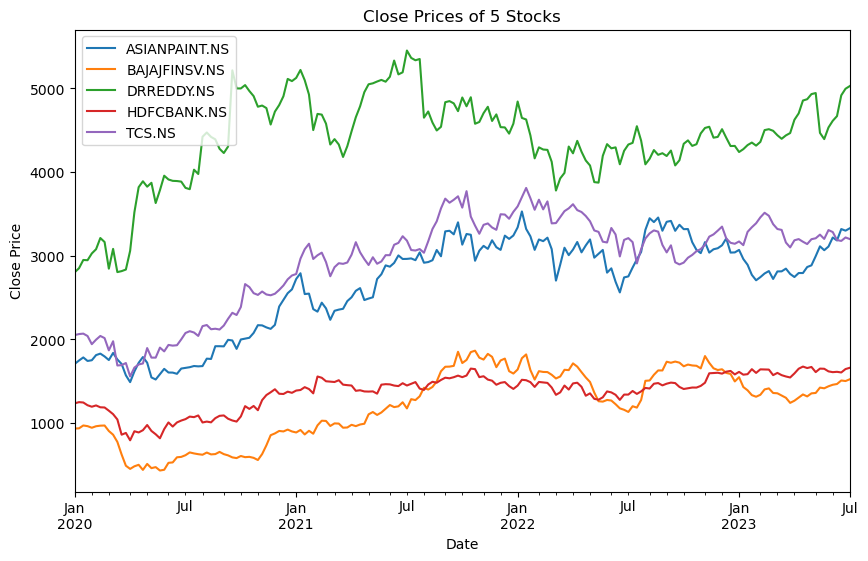

In [79]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'data' with close prices for 5 stocks
data.plot(figsize=(10, 6))

# Set the labels and title
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Prices of 5 Stocks")

# Display the plot
plt.show()

In [80]:
# Calculate the daily returns
act_returns = data.pct_change()
act_returns = act_returns.dropna()  # Drop the first row as it will have NaN due to no previous value

# Calculate the average daily return over the available data
avg_dly_return = act_returns.mean()

annualized_return = avg_dly_return * 252

# Assign the expected returns to the variable in the code
returns = np.array(annualized_return)

In [81]:
avg_dly_return

ASIANPAINT.NS    0.004438
BAJAJFINSV.NS    0.004293
DRREDDY.NS       0.003993
HDFCBANK.NS      0.002392
TCS.NS           0.003060
dtype: float64

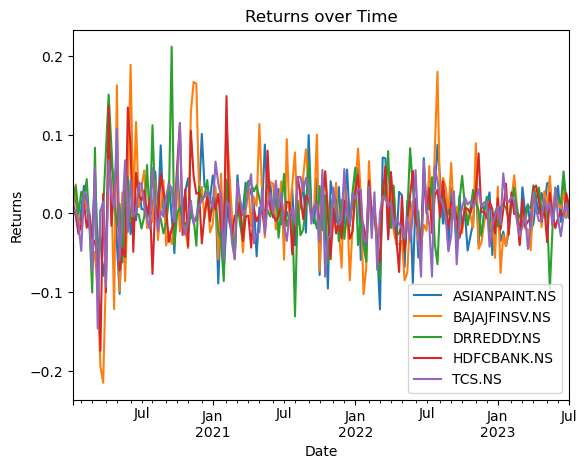

In [82]:
act_returns.plot()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns over Time')
plt.show()

c. Compute the covariance matrix from the observations.</br>

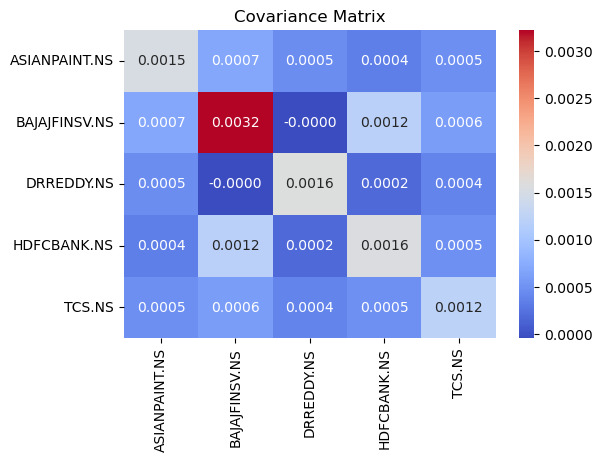

In [83]:
# Compute the covariance matrix
cov_matrix = act_returns.cov()

# Plot the covariance matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Covariance Matrix')
plt.show()

In [84]:
print(cov_matrix)

               ASIANPAINT.NS  BAJAJFINSV.NS  DRREDDY.NS  HDFCBANK.NS    TCS.NS
ASIANPAINT.NS       0.001522       0.000684    0.000455     0.000351  0.000472
BAJAJFINSV.NS       0.000684       0.003219   -0.000042     0.001197  0.000598
DRREDDY.NS          0.000455      -0.000042    0.001588     0.000181  0.000383
HDFCBANK.NS         0.000351       0.001197    0.000181     0.001551  0.000486
TCS.NS              0.000472       0.000598    0.000383     0.000486  0.001222


In [85]:
def plot_weights(dat, title):
    # Create a bar plot for the portfolio weights
    n_assets = 5
    plt.figure(figsize=(7, 3))
    bars = plt.bar(range(n_assets), dat, align='center', color='orange')
    plt.xticks(range(n_assets), tickers)
    plt.xlabel('Asset')
    plt.ylabel('Weight')
    plt.title(title)
    plt.grid(False)

    # Add value labels to the bar plot
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}",
                 ha='center', va='top')

    plt.show()

d. Run a classical Markowitz portfolio optimization. Be sure to print / display
/ graph the weights of each security in the portfolio optimization results.

In [86]:
#Data Frame to store the weights arrived from different models
portfolio_weights = pd.DataFrame(columns=tickers)

In [87]:
# Define function to maximise sharpe ratio using Markowitz optimisation
def calc_neg_sharpe(weights, mean_ret, cov, rf):
    ptfl_ret = np.sum(mean_ret * weights) * 252
    ptfl_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (ptfl_ret - rf) / ptfl_std
    return -sharpe_ratio

def max_sharpe_ratio(mean_ret, cov, rf):
    num_assets = len(mean_ret)
    args = (mean_ret, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
rf = 0.02
optimal_portfolio_sharpe = max_sharpe_ratio(returns, cov_matrix, rf)

In [88]:
portfolio_weights.loc['Original'] = optimal_portfolio_sharpe['x']

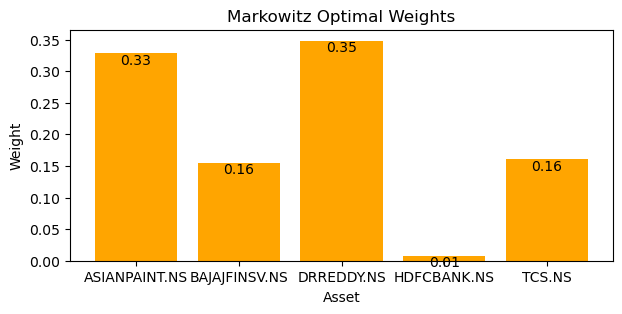

In [89]:
plot_weights(optimal_portfolio_sharpe['x'], 'Markowitz Optimal Weights')
portfolio_weights = portfolio_weights.round(2)

Avg Daily return and annualized return for HDFC Bank is the lowest and therefore it has been assigned minimal weight.

In [90]:
portfolio_weights

,ASIANPAINT.NS,BAJAJFINSV.NS,DRREDDY.NS,HDFCBANK.NS,TCS.NS
Original,0.33,0.16,0.35,0.01,0.16


### Step 2: Black-Litterman

a. Find recent news, headlines, analyst reports, etc. that can be quantitatively translated into new values of returns and volatilities within the Black-Litterman framework.

b. Apply the BL portfolio optimization. Compare the original portfolio allocation with the BL results. The comparison should include differences in weights and performance.

In [91]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as sco
#market snapshot as off 5th July 2023
mkt_data_nifty=pd.read_csv("MW-NIFTY-50-05-Jul-2023.csv")
mkt_data_nifty.set_index("SYMBOL \n",inplace=True)
mkt_top_50=mkt_data_nifty.iloc[1:,:]
mkt_top_50["eq_mkt_wt"]=mkt_top_50["VALUE "].apply(float)/float(mkt_data_nifty.iloc[0,8])
mkt_top_50.head()

,OPEN \n,HIGH \n,LOW \n,PREV. CLOSE \n,LTP \n,CHNG \n,%CHNG \n,VOLUME \n(shares),VALUE,52W H \n,52W L \n,365 D % CHNG \n 30-Jun-2022,30 D % CHNG \n 31-May-2023,eq_mkt_wt
SYMBOL,,,,,,,,,,,,,,
BAJAJ-AUTO,"4,647.95","4,900.00","4,633.00","4,625.40","4,900.00",274.60,5.94,"891,033",4.271978e+09,"4,900.00","3,461.25",25.70,-0.94,0.017296
DIVISLAB,"3,576.40","3,775.00","3,563.15","3,550.10","3,760.05",209.95,5.91,"1,611,582",5.942096e+09,"3,973.90","2,730.00",-2.46,1.10,0.024058
HDFCLIFE,647,675.95,645.05,647,675,28.00,4.33,"5,871,642",3.913038e+09,675.95,457.8,12.66,12.25,0.015843
MARUTI,"9,697.00","10,036.95","9,675.00","9,647.40","9,990.10",342.70,3.55,"815,044",8.057346e+09,"10,036.95","8,076.05",14.26,1.71,0.032622
HEROMOTOCO,"3,050.00","3,172.00","3,030.20","3,029.80","3,135.80",106.00,3.50,"3,069,147",9.573836e+09,"3,172.00","2,246.00",9.76,4.74,0.038762


In [92]:
#data extraction
tickers = ['ASIANPAINT.NS', 'BAJAJFINSV.NS', 'DRREDDY.NS', 'HDFCBANK.NS', 'TCS.NS']

start_date = '2020-01-01'
end_date = '2023-06-30'
#Daily data extraction
data = yf.download(tickers, start=start_date, end=end_date, period='1d', auto_adjust=True)['Close']

[*********************100%***********************]  5 of 5 completed


In [93]:
#all necessary variables
mkt_sharpe_ratio = 1.67
mkt_volatility=0.75
rf_rate=0.02
r=1/(data.shape[0]-data.shape[1])
port_eq_wts=mkt_top_50.loc[['ASIANPAINT','BAJAJFINSV','DRREDDY','HDFCBANK','TCS'],"eq_mkt_wt"]
port_eq_wts.index=tickers
# port_eq_wts=port_eq_wts/port_eq_wts.sum()
port_eq_wts

ASIANPAINT.NS    0.008642
BAJAJFINSV.NS    0.013161
DRREDDY.NS       0.005902
HDFCBANK.NS      0.126520
TCS.NS           0.019522
Name: eq_mkt_wt, dtype: float64

In [94]:
#manager views
P=np.array([[1,0,0,0,0],[0,-1,0,1,0],[0,0,1,0,0]])
Q=np.array([-0.05,0.025,0.1])

In [95]:
#BL implementation
#return calculation
returns = data.pct_change()
returns = returns.dropna()
#cov_matrix
covar=returns.cov()
#Step-2 calculation of pie-posterior estimate of expected returns
pie=mkt_sharpe_ratio*np.matmul(covar,port_eq_wts)
delta=r*covar
omega= np.matmul(np.matmul(P,delta),P.T)

In [96]:
#expected posterior return
exp_post_ret=pie+np.matmul(np.matmul(np.matmul(delta,P.T),np.linalg.inv(omega+np.matmul(P,np.matmul(delta,P.T)))),(Q-np.matmul(P,pie)))
exp_post_ret

ASIANPAINT.NS   -0.024982
BAJAJFINSV.NS   -0.014694
DRREDDY.NS       0.050009
HDFCBANK.NS     -0.002189
TCS.NS           0.003040
dtype: float64

In [97]:
exp_post_covar=covar+np.linalg.inv(np.linalg.inv(delta)+np.matmul(P.T,np.matmul(np.linalg.inv(omega),P)))
exp_post_covar

,ASIANPAINT.NS,BAJAJFINSV.NS,DRREDDY.NS,HDFCBANK.NS,TCS.NS
ASIANPAINT.NS,0.000321,0.000172,0.000084,0.000109,0.000098
BAJAJFINSV.NS,0.000172,0.000639,0.000066,0.000255,0.000144
DRREDDY.NS,0.000084,0.000066,0.000300,0.000050,0.000079
HDFCBANK.NS,0.000109,0.000255,0.000050,0.000351,0.000111
TCS.NS,0.000098,0.000144,0.000079,0.000111,0.000268


In [98]:
# Define function to maximise maximising function
def max_function(weights, mean_ret, cov, rf):
    a=np.matmul(weights.T,mean_ret)
    b=0.5*np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    op_fun = a-b
    return -op_fun

def max_sharpe_ratio(mean_ret, cov, rf):
    num_assets = len(mean_ret)
    args = (mean_ret, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(max_function, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [99]:
optimal_portfolio_sharpe = max_sharpe_ratio(exp_post_ret, exp_post_covar, rf_rate)
opt_wts=optimal_portfolio_sharpe['x']
opt_wts=opt_wts/opt_wts.sum()

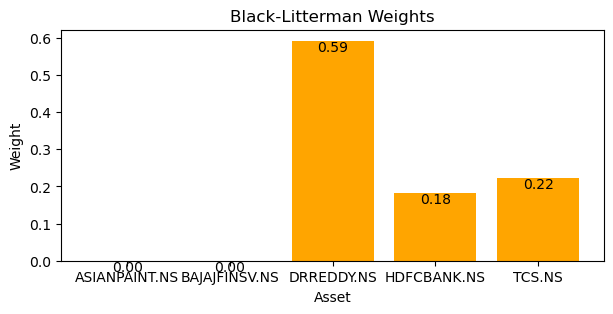

In [100]:
plot_weights(opt_wts, 'Black-Litterman Weights')

In [101]:
portfolio_weights.loc['BL'] = opt_wts
portfolio_weights = portfolio_weights.round(2)

In [102]:
portfolio_weights

,ASIANPAINT.NS,BAJAJFINSV.NS,DRREDDY.NS,HDFCBANK.NS,TCS.NS
Original,0.33,0.16,0.35,0.01,0.16
BL,0.00,0.00,0.59,0.18,0.22


### Step 3: Kelly Criterion
</br>**Code Credit: Chawla, Karan. "The Kelly Criterion." Github. https://github.com/1kc2/The-Kelly-Criterion. Suggested Reference in Module 5 Lesson 1**

In [103]:
def get_kelly(returns, window=22, r=0.02, correlation=False):
    """Gets Kelly optimal investment fraction
    Parameters:
    -----------
    returns : pd.DataFrame or pd.Series (Series containing the daily returns of a security)
    window : int, optional (Minimum periods to calculate the parameters. Default 400.)
    r : int, optional (Risk-free yearly returns. Example: Treasury bills. Default 0.02.)
    correlation : bool, optional (If a portfolio of securities is given, indicate whether the securities are correlationated 
                                  or not.)      
    Returns:
    --------
    kelly : pd.DataFrame (Frame containing the corresponding kelly values for each security)
    """
    days = 252
    r_adjusted = (1 + r) ** (1 / days) - 1
    mean = returns.expanding(window).mean()
    return_exces = mean - r_adjusted

    if correlation:
        roll_cov = returns.expanding(window).cov()
        roll_inv_cov = roll_cov.copy()
        kelly = pd.DataFrame(columns=mean.columns) 

        for day in returns.index:
            roll_inv_cov.loc[day] = np.linalg.inv(roll_cov.loc[day])
            kelly.loc[day] = np.dot(roll_inv_cov.loc[day], return_exces.loc[day])
            
    else:
        var = returns.expanding(window).var()
        kelly = return_exces / var
    
    kelly = kelly.dropna()
    
    return kelly


def filter_leverage(serie, leverage):
    """filters leverage
    Parameters
    ----------
    serie : pd.Series
    leverage : int
    Returns
    -------
    filtered_serie : pd.Series
    """
    
    filtered_serie = serie.copy()
    filtered_serie[filtered_serie>leverage] = leverage
    
    return filtered_serie


def get_cumulative_returns(returns):
    """Gets cumulative returns
    Parameters
    ----------
    returns : pd.Series, pd.DataFrame
    Returns
    ------- 
    cum_returns : pd.Series, pd.DataFrame
    """
    cum_returns = (1 + returns).cumprod()
    cum_returns = cum_returns.dropna()
    
    return cum_returns

def backtest(kelly_df, returns_df, leverages):
    """Backtests Kelly strategy
    Parameters
    ----------
    kelly_df : pd.DataFrame (kelly optimal allocations for the securities)
    returns_df : pd.DataFrame (daily returns of the securities)
    leverages : list (list containing the number of leverages to study)
    Returns
    -------
    total_returns : pd.DataFrame
    """
    
    total_returns = pd.DataFrame()

    for leverage in leverages:
        kelly_weights = kelly_df.copy()

        # restrict shortselling
        kelly_weights[kelly_weights<0] = 0

        daily_weights_sum = kelly_weights.sum(axis=1) if isinstance(kelly_weights, pd.DataFrame) else kelly_weights
        leverage_cond = daily_weights_sum > leverage

        kelly_weights[leverage_cond] = leverage * kelly_weights[leverage_cond].div(daily_weights_sum[leverage_cond], axis=0)

        name = 'max_leverage_' + str(leverage) 
        total_returns[name] = (returns_df * kelly_weights).sum(axis=1) if isinstance(kelly_weights, pd.DataFrame) else (returns_df * kelly_weights)
        
    return total_returns, kelly_weights

<Axes: >

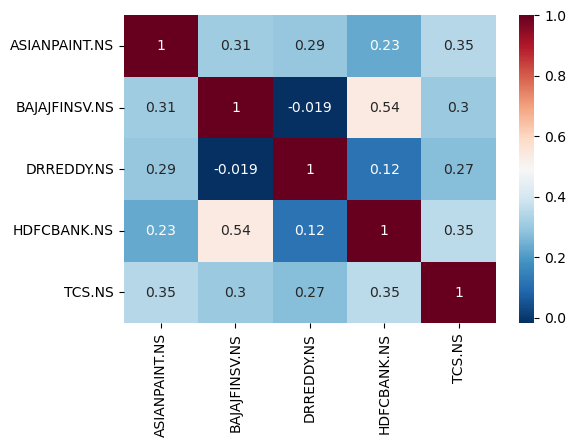

In [104]:
plt.figure(figsize=(6, 4))
sns.heatmap(act_returns.corr(), annot = True, cmap="RdBu_r")

In [105]:
print(act_returns.corr())

               ASIANPAINT.NS  BAJAJFINSV.NS  DRREDDY.NS  HDFCBANK.NS    TCS.NS
ASIANPAINT.NS       1.000000       0.309008    0.292501     0.228521  0.346265
BAJAJFINSV.NS       0.309008       1.000000   -0.018653     0.535769  0.301440
DRREDDY.NS          0.292501      -0.018653    1.000000     0.115451  0.274557
HDFCBANK.NS         0.228521       0.535769    0.115451     1.000000  0.353180
TCS.NS              0.346265       0.301440    0.274557     0.353180  1.000000


a. Perform back-testing using the Kelly criterion for each security in the portfolio to size the allocation to that security.

In [106]:
window = 22
expanding_kelly = get_kelly(act_returns, correlation=True)
next_day_return = act_returns.shift(-1).tail(len(expanding_kelly))

leverage = [1.0]
backtest_daily_ret, kel_weights = backtest(expanding_kelly, next_day_return, leverage)
kel_weights_mean = np.round(np.mean(kel_weights, axis=0),2)
portfolio_weights.loc['Kelly'] = kel_weights_mean
portfolio_weights = portfolio_weights.round(2)

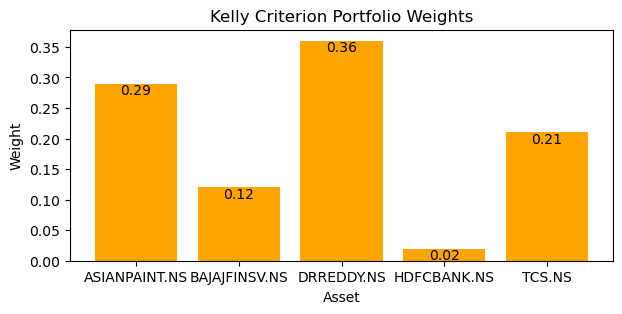

In [107]:
plot_weights(kel_weights_mean, 'Kelly Criterion Portfolio Weights')

In [108]:
portfolio_weights

,ASIANPAINT.NS,BAJAJFINSV.NS,DRREDDY.NS,HDFCBANK.NS,TCS.NS
Original,0.33,0.16,0.35,0.01,0.16
BL,0.00,0.00,0.59,0.18,0.22
Kelly,0.29,0.12,0.36,0.02,0.21


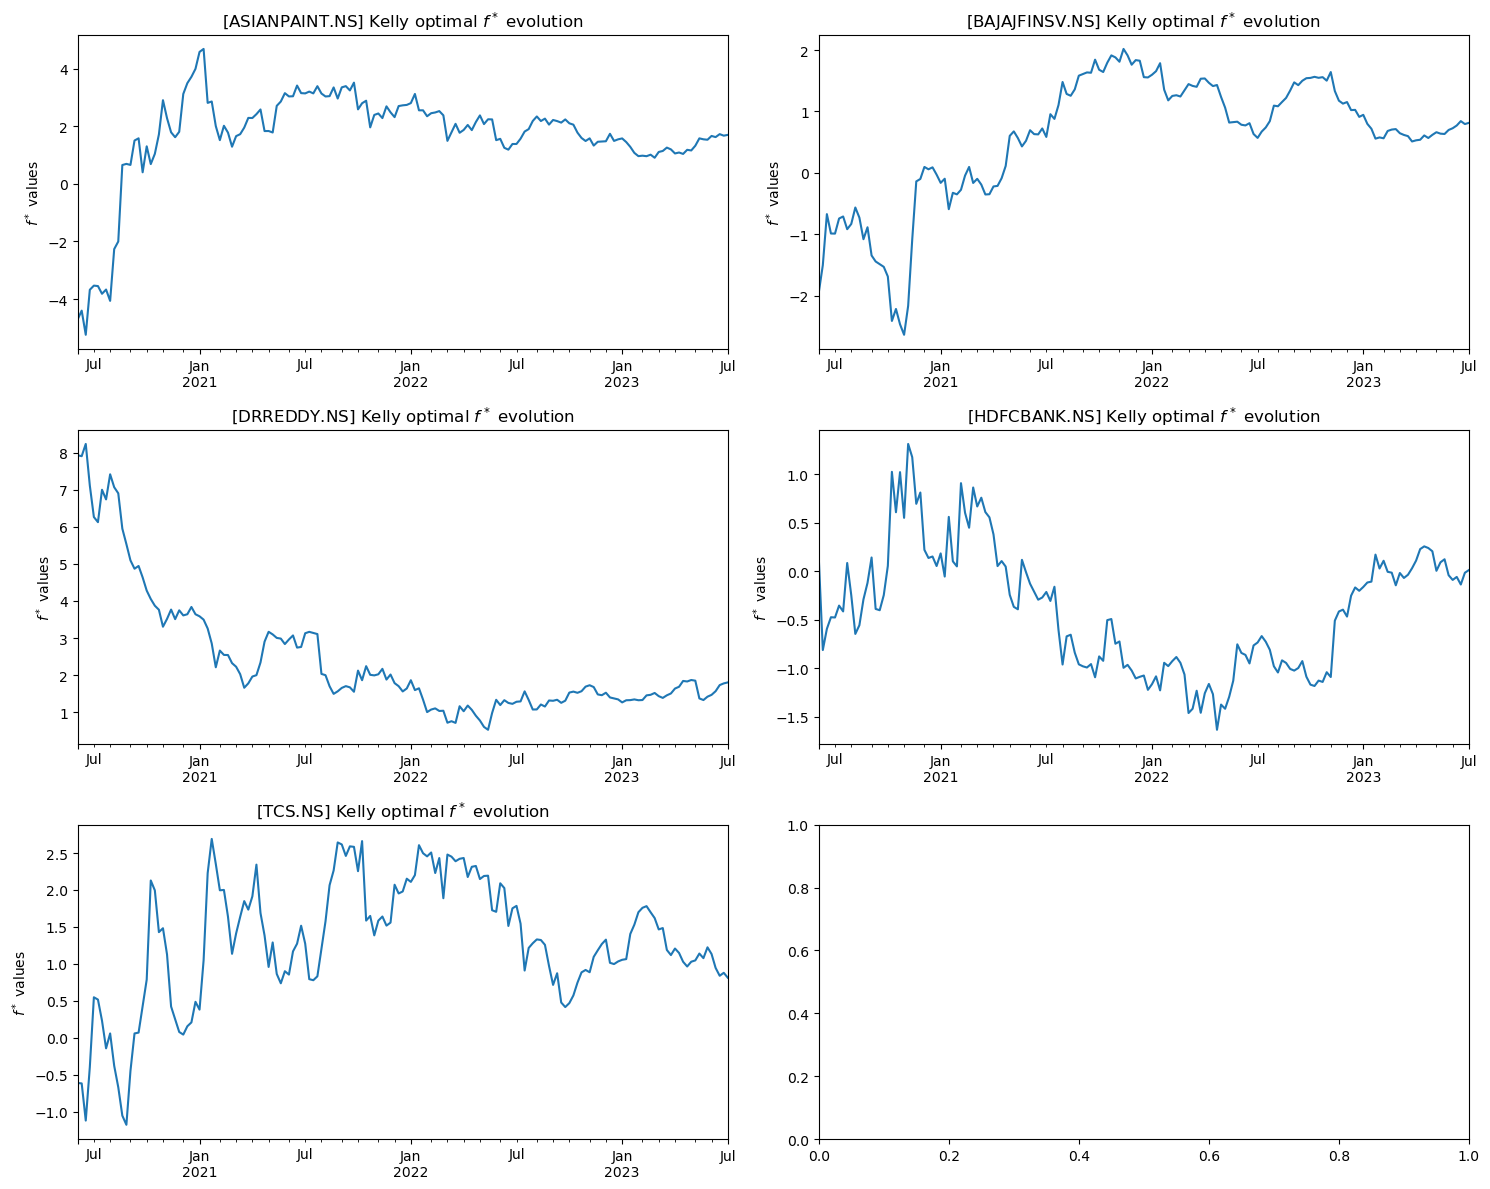

In [109]:
import math
num_tickers = len(tickers)
num_plots = math.ceil(num_tickers / 2)  # Number of rows

fig, axs = plt.subplots(nrows=num_plots, ncols=2, figsize=(15, 4 * num_plots))

for i, ticker in enumerate(tickers):
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    expanding_kelly[ticker].plot(ax=ax)
    ax.set_ylabel('$f^*$ values')
    ax.set_title(f'[{ticker}] Kelly optimal $f^*$ evolution')

plt.tight_layout()
plt.show()

b. Perform a series of historical backtests to see how the combined portfolio performs.

In [110]:
cumulative_return_df = get_cumulative_returns(backtest_daily_ret)
kelly_ret = backtest_daily_ret.mean()*252
kelly_stddev = backtest_daily_ret.std()
kelly_sharpe = (kelly_ret - rf)/(kelly_stddev * np.sqrt(252))

In [111]:
print("Kelly Returns      : {:.2%}".format(kelly_ret[0]))
print("Kelly Std. Dev.    : ", kelly_stddev[0].round(4))
print("Kelly Sharpe Ratio : ", kelly_sharpe[0].round(4))

Kelly Returns      : 55.89%
Kelly Std. Dev.    :  0.0288
Kelly Sharpe Ratio :  1.1805


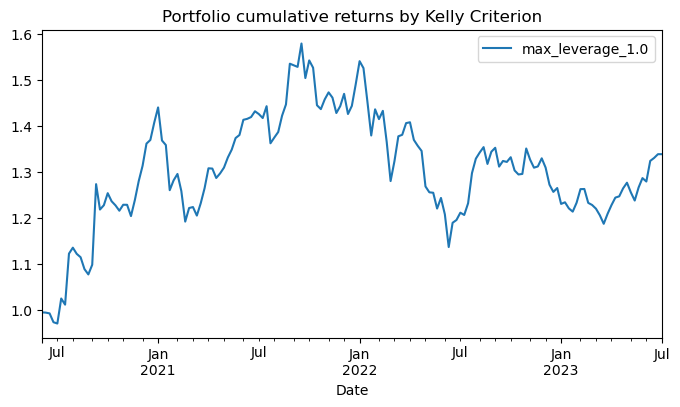

In [112]:
cumulative_return_df.plot(figsize=(8, 4), title="Portfolio cumulative returns by Kelly Criterion")
plt.show()

### Step 4: Leverage Constraints

a. Apply a leverage constraint smaller than Kelly (such as half-Kelly).

In [113]:
leverage = [0.5]
backtest_daily_ret, kel_weights = backtest(expanding_kelly, next_day_return, leverage)
cumulative_return_df = get_cumulative_returns(backtest_daily_ret)
kelly_weights_half  = np.mean(kel_weights, axis=0)
portfolio_weights.loc['Half Kelly'] = kelly_weights_half
portfolio_weights = portfolio_weights.round(2)

kelly_ret_lc = backtest_daily_ret.mean()*252
kelly_stddev_lc = backtest_daily_ret.std()
kelly_sharpe_lc = (kelly_ret_lc - rf)/(kelly_stddev_lc * np.sqrt(252))

print("HALF-KELLY:")
print("Kelly Returns      : {:.2%}".format(kelly_ret_lc[0]))
print("Kelly Std. Dev.    : ", kelly_stddev_lc[0].round(4))
print("Kelly Sharpe Ratio : ", kelly_sharpe_lc[0].round(4))

HALF-KELLY:
Kelly Returns      : 27.95%
Kelly Std. Dev.    :  0.0144
Kelly Sharpe Ratio :  1.1367


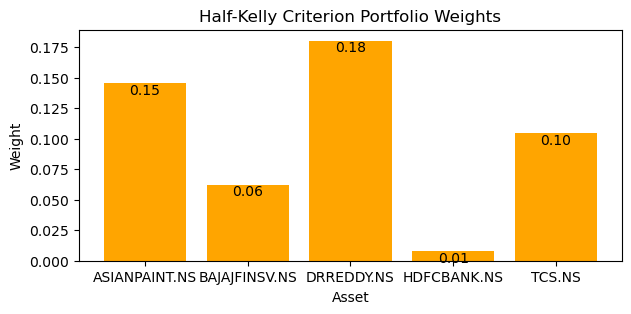

In [114]:
plot_weights(kelly_weights_half, 'Half-Kelly Criterion Portfolio Weights')

b. Apply a leverage constraint larger than Kelly (such as two to five times Kelly).

In [115]:
leverage = [2]
backtest_daily_ret, kel_weights = backtest(expanding_kelly, next_day_return, leverage)
cumulative_return_df = get_cumulative_returns(backtest_daily_ret)
kelly_weights_2  = np.mean(kel_weights, axis=0)
portfolio_weights.loc['2 Kelly'] = kelly_weights_2
portfolio_weights = portfolio_weights.round(2)

kelly_ret_2k = backtest_daily_ret.mean()*252
kelly_stddev_2k = backtest_daily_ret.std()
kelly_sharpe_2k = (kelly_ret_2k - rf)/(kelly_stddev_2k * np.sqrt(252))
print("2-KELLY:")
print("Kelly Returns      : {:.2%}".format(kelly_ret_2k[0]))
print("Kelly Std. Dev.    : ", kelly_stddev_2k[0].round(4))
print("Kelly Sharpe Ratio : ", kelly_sharpe_2k[0].round(4))

2-KELLY:
Kelly Returns      : 111.79%
Kelly Std. Dev.    :  0.0575
Kelly Sharpe Ratio :  1.2024


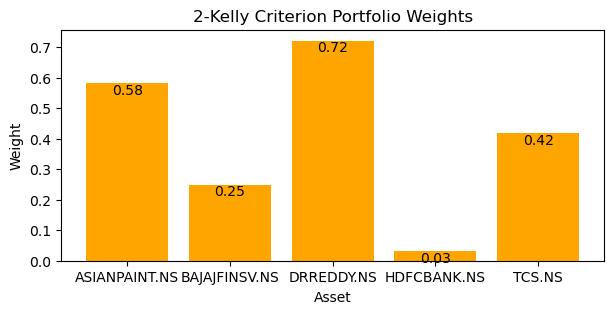

In [116]:
plot_weights(kelly_weights_2, '2-Kelly Criterion Portfolio Weights')

In [117]:
leverage = [3]
backtest_daily_ret, kel_weights = backtest(expanding_kelly, next_day_return, leverage)
cumulative_return_df = get_cumulative_returns(backtest_daily_ret)
kelly_weights_3  = np.mean(kel_weights, axis=0)
portfolio_weights.loc['3 Kelly'] = kelly_weights_3
portfolio_weights = portfolio_weights.round(2)

kelly_ret_3k = backtest_daily_ret.mean()*252
kelly_stddev_3k = backtest_daily_ret.std()
kelly_sharpe_3k = (kelly_ret_3k - rf)/(kelly_stddev_3k * np.sqrt(252))

print("3-KELLY:")
print("Kelly Returns      : {:.2%}".format(kelly_ret_3k[0]))
print("Kelly Std. Dev.    : ", kelly_stddev_3k[0].round(4))
print("Kelly Sharpe Ratio : ", kelly_sharpe_3k[0].round(4))

3-KELLY:
Kelly Returns      : 167.68%
Kelly Std. Dev.    :  0.0863
Kelly Sharpe Ratio :  1.2097


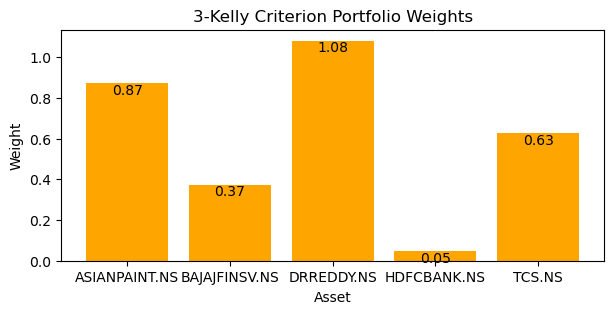

In [118]:
plot_weights(kelly_weights_3, '3-Kelly Criterion Portfolio Weights')

In [119]:
leverage = [4]
backtest_daily_ret, kel_weights = backtest(expanding_kelly, next_day_return, leverage)
cumulative_return_df = get_cumulative_returns(backtest_daily_ret)
kelly_weights_4  = np.mean(kel_weights, axis=0)
portfolio_weights.loc['4 Kelly'] = kelly_weights_4
portfolio_weights = portfolio_weights.round(2)

kelly_ret_4k = backtest_daily_ret.mean() * 252
kelly_stddev_4k = backtest_daily_ret.std()
kelly_sharpe_4k = (kelly_ret_4k - rf)/(kelly_stddev_4k * np.sqrt(252))

print("4-KELLY:")
print("Kelly Returns      : {:.2%}".format(kelly_ret_4k[0]))
print("Kelly Std. Dev.    : ", kelly_stddev_4k[0].round(4))
print("Kelly Sharpe Ratio : ", kelly_sharpe_4k[0].round(4))

4-KELLY:
Kelly Returns      : 223.58%
Kelly Std. Dev.    :  0.115
Kelly Sharpe Ratio :  1.2134


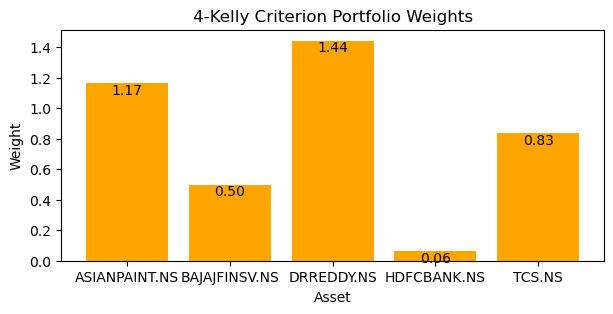

In [120]:
plot_weights(kelly_weights_4, '4-Kelly Criterion Portfolio Weights')

In [121]:
leverage = [5]
backtest_daily_ret, kel_weights = backtest(expanding_kelly, next_day_return, leverage)
cumulative_return_df = get_cumulative_returns(backtest_daily_ret)
kelly_weights_5  = np.mean(kel_weights, axis=0)
portfolio_weights.loc['5 Kelly'] = kelly_weights_5
portfolio_weights = portfolio_weights.round(2)

kelly_ret_5k = backtest_daily_ret.mean() * 252
kelly_stddev_5k = backtest_daily_ret.std()
kelly_sharpe_5k = (kelly_ret_5k - rf)/(kelly_stddev_5k * np.sqrt(252))
print("5-KELLY:")
print("Kelly Returns: {:.2%}".format(kelly_ret_5k[0]))
print("Kelly Std. Dev.   : ", kelly_stddev[0].round(4))
print("Kelly Sharpe Ratio: ", kelly_sharpe[0].round(4))

5-KELLY:
Kelly Returns: 274.32%
Kelly Std. Dev.   :  0.0288
Kelly Sharpe Ratio:  1.1805


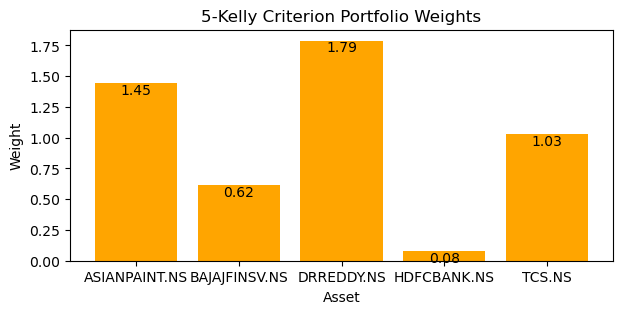

In [122]:
plot_weights(kelly_weights_5, '5-Kelly Criterion Portfolio Weights')

In [123]:
portfolio_weights = portfolio_weights.round(2)

In [124]:
portfolio_weights

,ASIANPAINT.NS,BAJAJFINSV.NS,DRREDDY.NS,HDFCBANK.NS,TCS.NS
Original,0.33,0.16,0.35,0.01,0.16
BL,0.00,0.00,0.59,0.18,0.22
Kelly,0.29,0.12,0.36,0.02,0.21
Half Kelly,0.15,0.06,0.18,0.01,0.10
2 Kelly,0.58,0.25,0.72,0.03,0.42
3 Kelly,0.87,0.37,1.08,0.05,0.63
4 Kelly,1.17,0.50,1.44,0.06,0.83
5 Kelly,1.45,0.62,1.79,0.08,1.03


### Step 5: Combine Methods

a. Compare the original portfolio allocation, BL allocation, Kelly allocation, and Leverage Constraint.

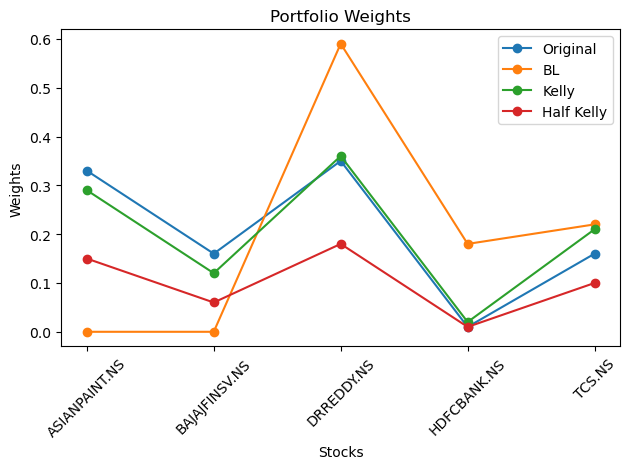

In [125]:
# Read the portfolio weights from the dataframe
stocks = portfolio_weights.columns.tolist()
original = portfolio_weights.loc['Original'].tolist()
bl = portfolio_weights.loc['BL'].tolist()
kelly = portfolio_weights.loc['Kelly'].tolist()
half_kelly = portfolio_weights.loc['Half Kelly'].tolist()

# Set up the plot
fig, ax = plt.subplots()

# Plot the data
ax.plot(stocks, original, marker='o', label='Original')
ax.plot(stocks, bl, marker='o', label='BL')
ax.plot(stocks, kelly, marker='o', label='Kelly')
ax.plot(stocks, half_kelly, marker='o', label='Half Kelly')

# Add labels and title
ax.set_xlabel('Stocks')
ax.set_ylabel('Weights')
ax.set_title('Portfolio Weights')

# Set the tick labels
ax.set_xticklabels(stocks, rotation=45)

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [126]:
portfolio_weights

,ASIANPAINT.NS,BAJAJFINSV.NS,DRREDDY.NS,HDFCBANK.NS,TCS.NS
Original,0.33,0.16,0.35,0.01,0.16
BL,0.00,0.00,0.59,0.18,0.22
Kelly,0.29,0.12,0.36,0.02,0.21
Half Kelly,0.15,0.06,0.18,0.01,0.10
2 Kelly,0.58,0.25,0.72,0.03,0.42
3 Kelly,0.87,0.37,1.08,0.05,0.63
4 Kelly,1.17,0.50,1.44,0.06,0.83
5 Kelly,1.45,0.62,1.79,0.08,1.03


b. Show how different combinations (all 3, BL & Kelly, BL & LC, Kelly & LC, etc.) compare in performance using metrics that you choose.

In [127]:
# All 3
corr_kelly = get_kelly(act_returns, correlation=True)
next_day_return = act_returns.shift(-1).tail(len(corr_kelly))
combine_3 = corr_kelly.copy(deep=True)

for ticker in tickers:
    kelly_weight = combine_3[ticker]*portfolio_weights.loc['Kelly'][ticker]*1/3
    bl_weight = portfolio_weights.loc['BL'][ticker]*1/3
    original_weight = portfolio_weights.loc['Original'][ticker]*1/3
    combine_3[ticker] = (kelly_weight + bl_weight + original_weight)

leverage = [1.0]
combine_3_backtest_daily_ret, combine_3_weights = backtest(combine_3, next_day_return, leverage)
combine_3_cum_ret = get_cumulative_returns(combine_3_backtest_daily_ret)

combine_3_mean_ret = combine_3_backtest_daily_ret.mean() * 252
combine_3_stddev = combine_3_backtest_daily_ret.std()
combine_3_sharpe = (combine_3_mean_ret - rf)/(combine_3_stddev * np.sqrt(252))

print("ALL 3:")
print("Return       : {:.2%}".format(combine_3_mean_ret[0]))
print("Std Dev.     : ", combine_3_stddev[0].round(4))
print("Sharpe Ratio : ", combine_3_sharpe[0].round(4))

ALL 3:
Return       : 68.40%
Std Dev.     :  0.0268
Sharpe Ratio :  1.561


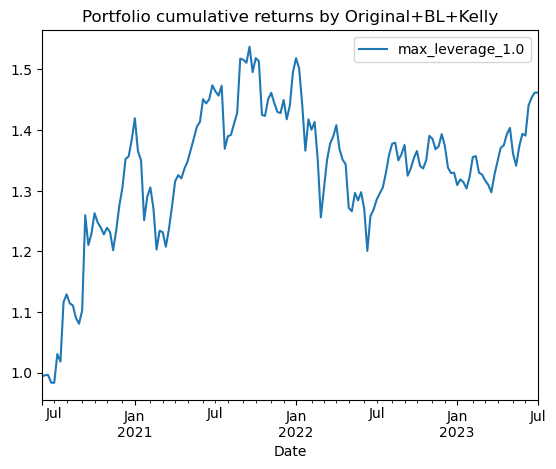

In [128]:
combine_3_cum_ret.plot(title="Portfolio cumulative returns by Original+BL+Kelly")
plt.show()

In [129]:
# BL & Kelly
corr_kelly = get_kelly(act_returns, correlation=True)
next_day_return = act_returns.shift(-1).tail(len(corr_kelly))
bl_kelly = corr_kelly.copy(deep=True)

for ticker in tickers:
    kelly_weight = bl_kelly[ticker]*portfolio_weights.loc['Kelly'][ticker]*1/2
    bl_weight = portfolio_weights.loc['BL'][ticker]*1/2
    bl_kelly[ticker] = (kelly_weight + bl_weight)

leverage = [1.0]
bl_kelly_backtest_daily_ret, bl_kelly_weights = backtest(bl_kelly, next_day_return, leverage)
bl_kelly_cum_ret = get_cumulative_returns(bl_kelly_backtest_daily_ret)

bl_kelly_mean_ret = bl_kelly_backtest_daily_ret.mean() * 252
bl_kelly_stddev = bl_kelly_backtest_daily_ret.std()
bl_kelly_sharpe = (bl_kelly_mean_ret - rf)/(bl_kelly_stddev * np.sqrt(252))

print("BL + KELLY:")
print("Return       : {:.2%}".format(bl_kelly_mean_ret[0]))
print("Std Dev.     : ", bl_kelly_stddev[0].round(4))
print("Sharpe Ratio : ", bl_kelly_sharpe[0].round(4))

BL + KELLY:
Return       : 59.00%
Std Dev.     :  0.0274
Sharpe Ratio :  1.3116


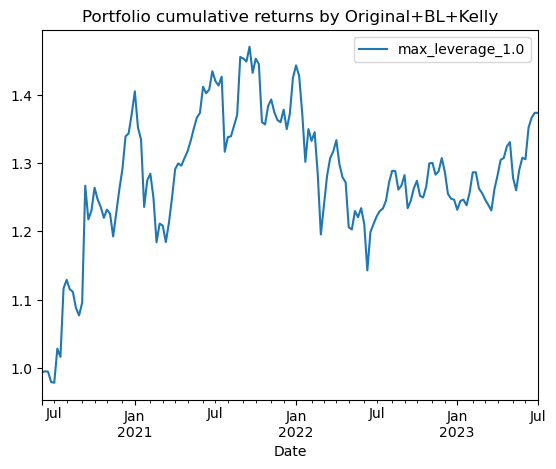

In [130]:
bl_kelly_cum_ret.plot(title="Portfolio cumulative returns by Original+BL+Kelly")
plt.show()

In [131]:
# BL & LC
corr_kelly = get_kelly(act_returns, correlation=True)
next_day_return = act_returns.shift(-1).tail(len(corr_kelly))
bl_lc = corr_kelly.copy(deep=True)

for ticker in tickers:
    kelly_weight = bl_lc[ticker]
    bl_weight = portfolio_weights.loc['BL'][ticker]*1/2
    lc_weight = portfolio_weights.loc['Half Kelly'][ticker]*1/2
    bl_lc[ticker] = (kelly_weight + bl_weight + lc_weight)

leverage = [1.0]
bl_lc_backtest_daily_ret, bl_lc_weights = backtest(bl_lc, next_day_return, leverage)
bl_lc_cum_ret = get_cumulative_returns(bl_lc_backtest_daily_ret)

bl_lc_mean_ret = bl_lc_backtest_daily_ret.mean() * 252
bl_lc_stddev = bl_lc_backtest_daily_ret.std()
bl_lc_sharpe = (bl_lc_mean_ret - rf)/(bl_lc_stddev * np.sqrt(252))

print("BL + LC:")
print("Return       : {:.2%}".format(bl_lc_mean_ret[0]))
print("Std Dev.     : ", bl_lc_stddev[0].round(4))
print("Sharpe Ratio : ", bl_lc_sharpe[0].round(4))

BL + LC:
Return       : 57.06%
Std Dev.     :  0.0283
Sharpe Ratio :  1.2261


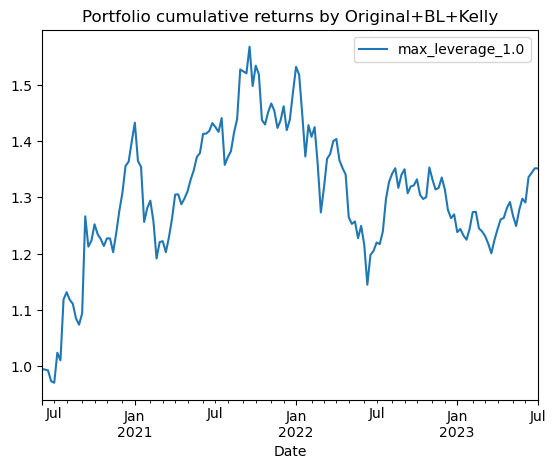

In [132]:
bl_lc_cum_ret.plot(title="Portfolio cumulative returns by Original+BL+Kelly")
plt.show()

In [133]:
# Kelly & LC
corr_kelly = get_kelly(act_returns, correlation=True)
next_day_return = act_returns.shift(-1).tail(len(corr_kelly))
kelly_lc = corr_kelly.copy(deep=True)

for ticker in tickers:
    kelly_weight = kelly_lc[ticker]*portfolio_weights.loc['Kelly'][ticker]*1/2
    lc_weight = portfolio_weights.loc['Half Kelly'][ticker]*1/2
    kelly_lc[ticker] = (kelly_weight + lc_weight)

leverage = [1.0]
kelly_lc_backtest_daily_ret, kelly_lc_weights = backtest(kelly_lc, next_day_return, leverage)
kelly_lc_cum_ret = get_cumulative_returns(kelly_lc_backtest_daily_ret)

kelly_lc_mean_ret = kelly_lc_backtest_daily_ret.mean() * 252
kelly_lc_stddev = kelly_lc_backtest_daily_ret.std()
kelly_lc_sharpe = (kelly_lc_mean_ret - rf)/(kelly_lc_stddev * np.sqrt(252))

print("KELLY + LC:")
print("Return       : {:.2%}".format(kelly_lc_mean_ret[0]))
print("Std Dev.     : ", kelly_lc_stddev[0].round(4))
print("Sharpe Ratio : ", kelly_lc_sharpe[0].round(4))

KELLY + LC:
Return       : 57.68%
Std Dev.     :  0.0283
Sharpe Ratio :  1.2379


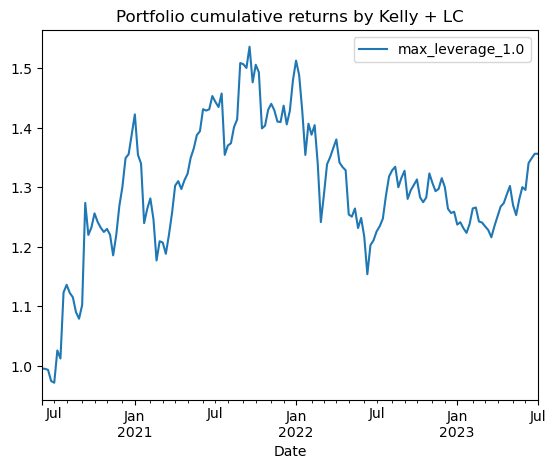

In [134]:
kelly_lc_cum_ret.plot(title="Portfolio cumulative returns by Kelly + LC")
plt.show()

c. Choose the single best combination and explain why it is optimal.